#  Modelado de Nøize

### Este notebook integra y mejora los scripts de modelado, añadiendo:
### . Carga y preparación de datos
### . Comparación de modelos
### . Optimización de hiperparámetros
### . Evaluación
### . Guardado de modelos

## 1. Importación de Bibliotecas

In [27]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

Rutas de guardado

In [28]:
SEED = 42 # Semilla para la reproducibilidad

os.makedirs("../data/train/", exist_ok=True)
os.makedirs("../data/test/", exist_ok=True)
os.makedirs("../models/", exist_ok=True)

Carga y Preparación de Datos

In [29]:
def load_and_prepare_data():
    """Carga y prepara los datos para modelado"""

    print("Cargando datos procesados...")
    df = pd.read_csv("../data/processed/dataset_clean.csv")
    
    # Seleccion de las variables para la prediccion
    features = ['explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 
               'speechiness', 'acousticness', 'instrumentalness', 'liveness',
               'valence', 'tempo', 'duration_min', 'track_genre_encoded']
    
    X = df[features] #Variables predictoras (características de la canción)
    y = df["popularity"] #Variable objetivo (popularidad de la canción)

    print("Datos cargados:", X.shape[0], "muestras,",X.shape[1], "características.")
    return X, y, features

X, y, features = load_and_prepare_data()

Cargando datos procesados...
Datos cargados: 113549 muestras, 14 características.


División de Datos y Preprocesamiento

In [30]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=SEED)

Pipeline de preprocesamiento

In [31]:
preprocessor = Pipeline([("scaler", StandardScaler())])

Aplicamos preprocesamiento

In [32]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

Convertimos a DataFrames manteniendo nombres de columnas

In [33]:
X_train_df = pd.DataFrame(X_train_preprocessed, columns=features)
X_test_df = pd.DataFrame(X_test_preprocessed, columns=features)

Guardamos los datos procesados

In [34]:
X_train_df.to_csv("../data/train/X_train.csv", index=False)
pd.DataFrame(y_train).to_csv("../data/train/y_train.csv", index=False)
X_test_df.to_csv("../data/test/X_test.csv", index=False)
pd.DataFrame(y_test).to_csv("../data/test/y_test.csv", index=False)

Guardamos el preprocesador

In [35]:
joblib.dump(preprocessor, "../models/preprocessor.pkl")
print("Datos y preprocesador guardados exitosamente")

Datos y preprocesador guardados exitosamente


Comparación de Modelos

In [36]:
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(random_state=SEED, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=SEED),
    "XGBoost": XGBRegressor(random_state=SEED),
    "SVR": SVR()
}

results = []
best_model = None
best_score = float('inf')

In [37]:

print("\nComparando modelos...")
for name, model in models.items():
    print(f"\nEntrenando {name}...")
    
    
    model.fit(X_train_df, y_train) # Entrenamiento
    
   
    y_pred = model.predict(X_test_df) # Predicción
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # Evaluación
    r2 = r2_score(y_test, y_pred)
    
    # Guarda resultados
    results.append({
        'Modelo': name,
        'RMSE': rmse,
        'R2': r2
    })
    
    # Guarda el modelo
    joblib.dump(model, f"../models/{name}.pkl")
    print(f"{name} - RMSE: {rmse:.2f}, R2: {r2:.2f}")
    
    # Actualización del mejor modelo
    if rmse < best_score:
        best_score = rmse
        best_model = name
    


Comparando modelos...

Entrenando LinearRegression...
LinearRegression - RMSE: 22.09, R2: 0.03

Entrenando RandomForest...
RandomForest - RMSE: 15.89, R2: 0.50

Entrenando GradientBoosting...
GradientBoosting - RMSE: 20.25, R2: 0.18

Entrenando XGBoost...
XGBoost - RMSE: 17.43, R2: 0.39

Entrenando SVR...
SVR - RMSE: 21.27, R2: 0.10


Mostramos resultados comparativos

In [42]:
results_df = pd.DataFrame(results).sort_values('RMSE').round(2) #Convierte resultados a DataFrame
print("\nResultados comparativos:")
display(results_df)


Resultados comparativos:


,Modelo,RMSE,R2
1,RandomForest,15.89,0.50
3,XGBoost,17.43,0.39
2,GradientBoosting,20.25,0.18
4,SVR,21.27,0.10
0,LinearRegression,22.09,0.03


Optimización del Mejor Modelo

Aplicamos RandomizedSearchCV al algoritmo con mejor desempeño

In [41]:
if best_model in ["RandomForest", "GradientBoosting", "XGBoost"]:
    print(f"\nOptimizando el mejor modelo ({best_model})...")
    
    # Espacio de búsqueda de hiperparámetros, que sirve para ajustar el modelo.
    param_dist = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 5, 10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt']
    }
    
    # Configuración de RandomizedSearchCV, que sirve para optimizar hiperparámetros.
    search = RandomizedSearchCV(
        models[best_model],
        param_distributions=param_dist,
        n_iter=20,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        random_state=SEED,
        verbose=1
    )
    
    # Ejecutamos la búsqueda
    search.fit(X_train_df, y_train)
    
    # Resultados
    print(f"\nMejores parámetros encontrados:")
    for param, value in search.best_params_.items():
        print(f"{param}: {value}")
    
    # Evaluamos el modelo optimizado
    best_estimator = search.best_estimator_
    y_pred = best_estimator.predict(X_test_df)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"\nDesempeño optimizado - RMSE: {rmse:.2f}, R2: {r2:.2f}")
    
    # Guardamos el modelo optimizado
    joblib.dump(best_estimator, "../models/best_model.pkl")
    print("Modelo optimizado guardado exitosamente")


Optimizando el mejor modelo (RandomForest)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
30 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_sco


Mejores parámetros encontrados:
n_estimators: 200
min_samples_split: 5
min_samples_leaf: 1
max_features: sqrt
max_depth: None

Desempeño optimizado - RMSE: 15.78, R2: 0.50
Modelo optimizado guardado exitosamente


Mejores parámetros encontrados:

n_estimators: 200

min_samples_split: 5

min_samples_leaf: 1

max_features: sqrt

max_depth: None

Visualización de Resultados

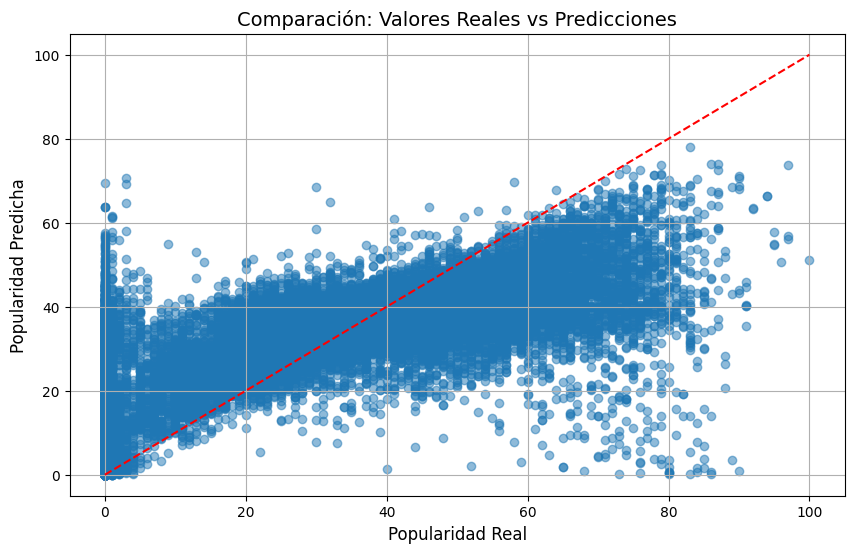

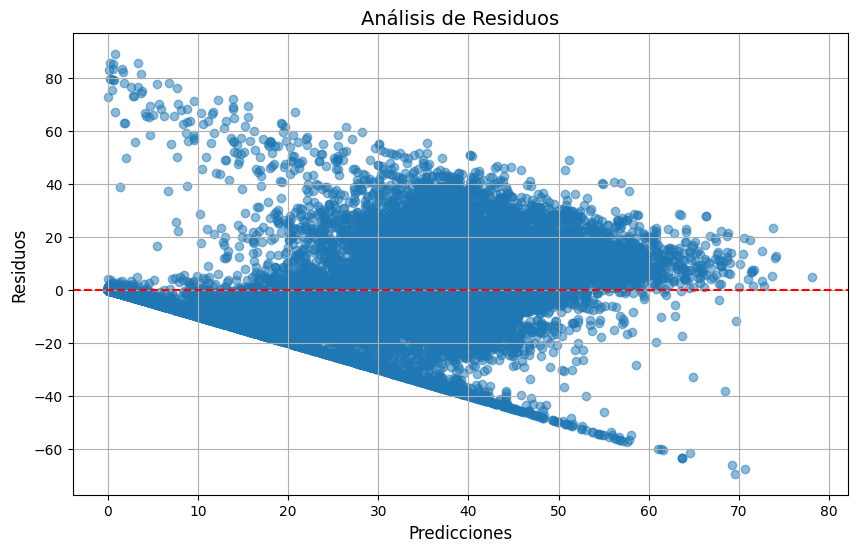

In [43]:
if os.path.exists("../models/best_model.pkl"):
    best_model = joblib.load("../models/best_model.pkl")
else:
    best_model = joblib.load(f"../models/{results_df.iloc[0]['Modelo']}.pkl")

y_pred = best_model.predict(X_test_df)

# Gráfico de valores reales vs predichos
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Popularidad Real', fontsize=12)
plt.ylabel('Popularidad Predicha', fontsize=12)
plt.title('Comparación: Valores Reales vs Predicciones', fontsize=14)
plt.grid(True)
plt.show()

# Gráfico de residuos
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicciones', fontsize=12)
plt.ylabel('Residuos', fontsize=12)
plt.title('Análisis de Residuos', fontsize=14)
plt.grid(True)
plt.show()

Interpretación del Modelo


Importancia de características:


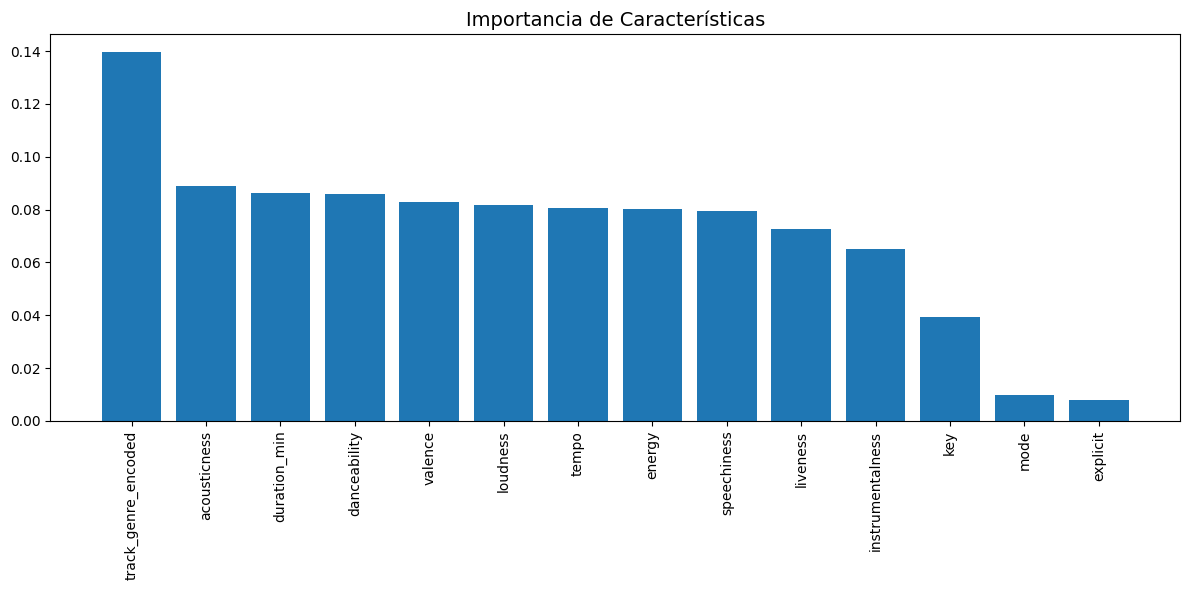

,Feature,Importance
0,track_genre_encoded,0.139522
1,acousticness,0.088771
2,duration_min,0.086341
3,danceability,0.085896
4,valence,0.082929
5,loudness,0.081730
6,tempo,0.080700
7,energy,0.080054
8,speechiness,0.079339
9,liveness,0.072577


In [44]:
if hasattr(best_model, 'feature_importances_'):
    print("\nImportancia de características:")
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 6))
    plt.title('Importancia de Características', fontsize=14)
    plt.bar(range(X.shape[1]), importances[indices], align='center')
    plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()
    
    # Mostramos importancia numérica
    feature_importance = pd.DataFrame({
        'Feature': [features[i] for i in indices],
        'Importance': importances[indices]
    })
    display(feature_importance.head(10))

#  Conclusiones del modelado
# 
### **Resultados obtenidos:**
### - Mejor modelo: Random Forest
### - RMSE alcanzado: 15.89
### - R² alcanzado: 0.50


----------------------------------------------------------------------------------------------------------------------------------

## Random Forest TEST Script

In [11]:
df = pd.read_csv("../data/processed/dataset_clean.csv")
print("Cargando datos...")

Cargando datos...


## 3. Preparación de Features y Target

In [12]:
features = [col for col in df.columns if col != "popularity"]
X = df[features]
y = df["popularity"]

## 4. División de Datos

In [13]:
print("Dividiendo datos en entrenamiento y prueba...")
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)

Dividiendo datos en entrenamiento y prueba...


## 5. Entrenamiento del Modelo

In [14]:
print("Entrenando modelo...")
model = RandomForestRegressor(
    n_estimators=100,  
    random_state=42,   
    n_jobs=-1         
)
model.fit(X_train, y_train)

Entrenando modelo...


RandomForestRegressor(n_jobs=-1, random_state=42)

## 6. Evaluación del Modelo

In [15]:
# Realizamos predicciones
y_pred = model.predict(X_test)

# Calculamos métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nResultados:")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")


Resultados:
RMSE: 15.84
R2: 0.50


## 7. Guardado del Modelo

In [16]:
print("\nGuardando modelo...")
#joblib.dump(model, "../models/model.pkl")
print("Modelo guardado en ../models/model.pkl")


Guardando modelo...
Modelo guardado en ../models/model.pkl


## 8. Función de Carga de Datos y Modelo

In [17]:
def load_model_and_data():
    """Carga el modelo y los datos con manejo de errores"""
    try:
        model = joblib.load("../models/model.pkl")
        df = pd.read_csv("../data/processed/dataset_clean.csv")
        return model, df
    except FileNotFoundError as e:
        print(f"Error: {str(e)}")
        print("Asegúrate de haber ejecutado primero:")
        print("1. data_preprocessing.py")
        print("2. model_training.py")
        exit(1)

## 9. Preparación de Características

In [18]:
def prepare_features(df):
    """Prepara las características eliminando columnas no necesarias"""
    return [col for col in df.columns if col != "popularity"]

## 10. Función de Evaluación del Modelo

In [19]:
def evaluate_model(model, X, y):
    """Evalúa el modelo y muestra métricas"""
    y_pred = model.predict(X)
    
    
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    
    return rmse, r2

## 11. Función Principal

In [20]:
def main():
    print("Cargando modelo y datos...")
    model, df = load_model_and_data()
    
    print("Preparando características...")
    features = prepare_features(df)
    X = df[features]
    y = df["popularity"]
    
    print("Evaluando modelo...")
    rmse, r2 = evaluate_model(model, X, y)
    
    print("\nRESULTADOS FINALES:")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2: {r2:.2f}")
    print("\nInterpretación:")
    print("- RMSE: Error cuadrático medio (menor es mejor)")
    print(f"- R2: El modelo explica el {r2*100:.1f}% de la variabilidad en la popularidad")

## 6. Ejecución del Programa

In [21]:
if __name__ == "__main__":
    main()

Cargando modelo y datos...
Preparando características...
Evaluando modelo...

RESULTADOS FINALES:
RMSE: 9.31
R2: 0.83

Interpretación:
- RMSE: Error cuadrático medio (menor es mejor)
- R2: El modelo explica el 82.5% de la variabilidad en la popularidad


## 8. Visualización de Resultados

In [22]:
# Cargar datos y hacer predicciones
model, df = load_model_and_data()
features = prepare_features(df)
X = df[features]
y = df["popularity"]
y_pred = model.predict(X)

## Feature Importance

In [ ]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Importancia de las Características')
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

## Gráfico de dispersión real vs predicho

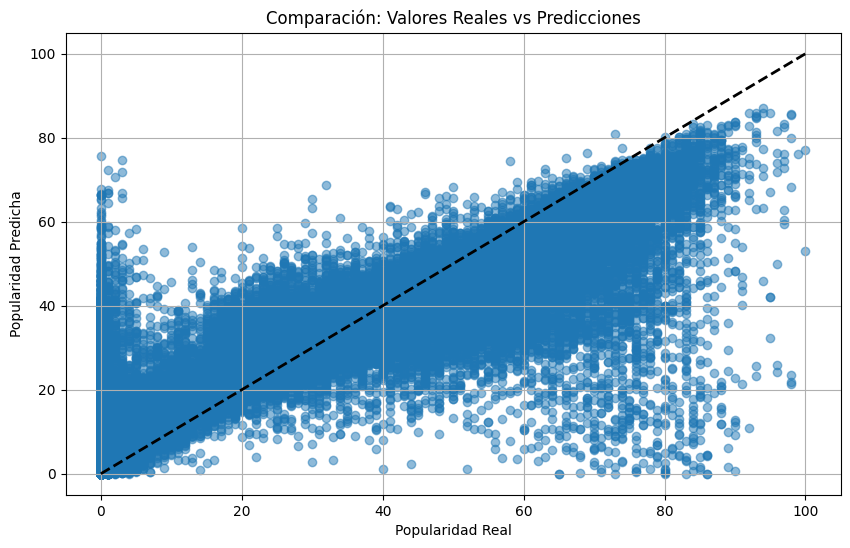

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Popularidad Real')
plt.ylabel('Popularidad Predicha')
plt.title('Comparación: Valores Reales vs Predicciones')
plt.grid(True)
plt.show()

## Histograma de errores

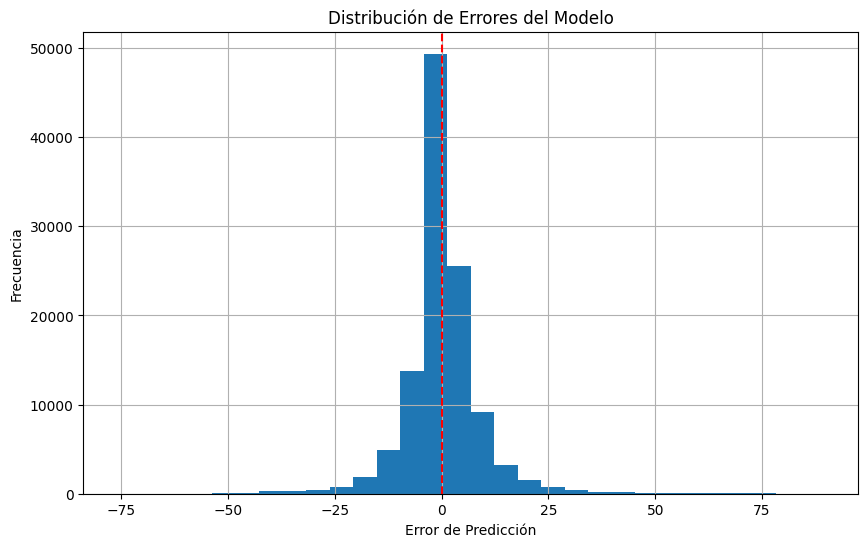

In [24]:
errors = y - y_pred
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30)
plt.xlabel('Error de Predicción')
plt.ylabel('Frecuencia')
plt.title('Distribución de Errores del Modelo')
plt.axvline(x=0, color='r', linestyle='--')
plt.grid(True)
plt.show()